# Feature extraction and transfer learning with pre-trained CNNs

## Task 1: Download training images

Our starting point is to find some pictures of objects that we want our neural network to recognize. To download training images of cats, for instance, you go to https://images.google.com/ and you type in "cat" and you just scroll through until you find a goodly bunch of them (say 200-400)

The next thing you need to do is to get a list of all the URLs there. To do that, back in your google images, you hit Ctrl-Shift-J in Windows/Linux and Cmd-Opt-J in Mac, and you paste the following into the window that appears:

```
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```



This will download a text file containing all the URLs. For now, just keep the file on your local machine. Rename the file to `<classname>.csv`. So for instance, if you downloaded URLs of cat images, you want to name the file `cat.csv`

Repeat the above process for each of the object categories, you wish to recognize. Pick 3 or more categories to make it more interesting. Below, I picked cat, dog, and horse.

##Task 2: Mount your Google Drive, create data directory, and upload csv files
Make a copy of this notebook in your Google Drive. And yes, you need to mount your Drive every time you start working on a notebook.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Create data directory. I prefer to use pathlab: https://docs.python.org/3/library/pathlib.html, but you can also use normal shell commands by prefixing with !

In [0]:
from pathlib import Path

root = '/content/gdrive/My Drive/' # Don't change this
data_dirname = 'data' # Change as you like
p = Path(root + data_dirname)
p.mkdir(exist_ok=True)

Now, let's upload the csv files to Google Colab. Click the ">" fan at the top left below the Colab logo.

![alt text](https://media.geeksforgeeks.org/wp-content/uploads/20190430123759/Screenshot-502.png)

This will open a menu where you can see file hierachy if you click Files.

![alt text](https://media.geeksforgeeks.org/wp-content/uploads/20190430124049/Screenshot-516.png)

To upload the csv files, locate the newly created data directory in the file hierarchy (if you used my code directly the path should be `/content/gdrive/My Drive/data`), then drag-and-drop the csv files from your local machine.

This should result in something like this:

In [0]:
[print(x) for x in p.iterdir() if x.is_file()]

/content/gdrive/My Drive/data/horse.csv
/content/gdrive/My Drive/data/cat.csv
/content/gdrive/My Drive/data/dog.csv


[None, None, None]

If you use shell commands, you can verify that the csv files have been uploaded by listing the content of the data directory:

In [0]:
!ls 'gdrive/My Drive/data'

cat.csv  dog.csv  horse.csv


Note that by default the current directory is /content. You can verify this by running the following command:

In [0]:
!pwd

/content


##Task 3: Download image files from URLs

The next step is to actually download the image files from the URLs in the csv files.

First specify which classes you want to include. Note that the class names must match the names given to the csv files:

In [0]:
classes = ['cat','dog','horse']

Then download the images (just ignore any error messages):

In [0]:
from fastai.vision.data import download_images
from fastai.vision.data import verify_images
max_pics = 400

for idx, name in enumerate(classes):
  print(name)
  folder = name
  file = name + '.csv'
  dest = p/folder
  dest.mkdir(parents=True, exist_ok=True)
  download_images(p/file, dest, max_pics=max_pics)

And remove files that are not actually images (again, just ignore any error messages):

In [0]:
for c in classes:
    print(c)
    verify_images(p/c, delete=True, max_size=500)

## Task 4: Set up neural network for feature extraction
Before proceeding *REMEMBER TO ENABLE GPU IN THE RUNTIME ENVIRONMENT:* Go to Runtime -> "Change runtime type" and select GPU as hardware acelerator.

We will be using a deep learning framework, called [Keras](https://keras.io/). Keras is a high-level neural network API, written in Python and capable of running on top of [TensorFlow](https://www.tensorflow.org/), CNTK, and Theano.

A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network. A pre-trained network is simply a saved network previously trained on a large dataset, such as the [ImageNet dataset](http://www.image-net.org/) (1.4 million labeled images and 1000 different classes). If this original dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these new problems might involve completely different classes from those of the original task.

In our case, we will consider a convolutional neural network (CNN) trained on ImageNet. We will use the MobileNet architecture, but there are other models that you could use as well. Take a look here: https://keras.io/applications

There are two ways to leverage a pre-trained network: feature extraction and fine-tuning. We will be covering both of them today. Let's start with feature extraction.

Feature extraction consists of using the representations learned by an existing neural network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch. This could be any classifier, such as K-Nearest Neighbours (K-NN).

CNNs comprise two parts: they start with a series of convolution and pooling layers, and they end with a densely-connected classifier. The first part is often referred to as the "encoder", "feature extractor" or "convolutional base" of the model. In the case of CNNs, "feature extraction" will simply consist of taking the convolutional base of a previously-trained network, running the new data through it, and training a new classifier on top of the output.

First, let's download and instantiate the pre-trained MobileNet without the top layers:

In [0]:
from keras.applications import MobileNet

conv_base = MobileNet(weights='imagenet',
                      include_top=False,
                      input_shape=(120, 120, 3))

Let's summarize the model used for feature extraction:

In [0]:
conv_base.summary()

###Questions 4.1
1. What is the expected shape of the input image?
2. What is the shape of the output of the model?
3. What happens to the output shape if you double the input shape?
4. Can you guess what the None dimension is used for?

##Task 5: Extract features from an image
Many neural networks expect the input image to have a fixed, pre-defined shape. Also, the pixel intensities are assumed to be in a fixed range. So for instance, if you train a network on images with intensities in the range -127.5 to 127.5, and you then feed the same network images with intensities in the range -0.5 to 0.5, the output of the network will most likely be garbage.

Fortunately each pre-trained network in Keras comes with its own preprocessor, which assures that the intensities are scaled correctly for that particular network.

Let's load an image, preprocess it, and feed it through the network:

In [0]:
import numpy as np
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input

# Pick first image of first class
filelist = [x for x in (p/classes[0]).iterdir() if x.is_file()]
img_path = filelist[0]
print(f"File path: {img_path}")

img = image.load_img(img_path, target_size=(120, 120))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_preprocessed = preprocess_input(img_data.copy())

mobilenet_features = conv_base.predict(img_preprocessed)

###Questions 5.1
1. What is the range of the pixel values before and after preprocessing?
2. So what formula do you think is used to pre-process the pixel values?
3. What is the order of the color channels? (you could compare with openCV)?
4.a) What is the size of the input image?
4.b) What is the size of the calculated feature representation?
4.c) So what is the reduction in dimensionality after feature extraction?

##Task 6: How to use the image generator 
Loading and preprocessing images is such a common thing in deep learning that frameworks like Keras provides predefined tools for us that we can use. 
In this task we will look at Keras' image data generator: https://keras.io/preprocessing/image/#imagedatagenerator-class. Simply put, the image generator is a tool that makes loading and preprocessing data easy.

Let's set up an image generator that outputs mini-batches of 32 images:


In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies
generator = datagen.flow_from_directory(str(p), # this is where you specify the path to the main data folder
                                        target_size=(120,120),
                                        color_mode='rgb',
                                        batch_size=32,
                                        class_mode='categorical',
                                        shuffle=True)

Found 1105 images belonging to 3 classes.


Here is one way to generate a new batch:

In [0]:
inputs, labels = generator.next()

###Questions 6.1
1. What is variable "inputs"?
2. What is variable "labels"?
3. How does the image generator know where the images are stored?
4. How does the image generator know the class of each image?
5. What does shuffle mean?

As you learned in lecture 2 it is always a good idea to split the data into a training set and a validation set. Again, this is such a common thing in deep learning that the image generator can do it for us:

In [0]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)

train_generator = datagen.flow_from_directory(str(p),
                                        target_size=(120,120),
                                        color_mode='rgb',
                                        batch_size=32,
                                        class_mode='categorical',
                                        shuffle=True,
                                        subset='training')
validation_generator = datagen.flow_from_directory(str(p),
                                        target_size=(120,120),
                                        color_mode='rgb',
                                        batch_size=32,
                                        class_mode='categorical',
                                        shuffle=True,
                                        subset='validation')

Found 885 images belonging to 3 classes.
Found 220 images belonging to 3 classes.


###Questions 6.2
1. How does each of the two generators know if it should produce training or validation images?
2. What is the validation percentage in this example?

Now, you can in principle create a complete training set and a validation set of images (this could take some time depending on the available GPU - feel free to read on while you are waiting):

In [0]:
def extract_features(generator,batch_size,num_batches):
    sample_count = batch_size * num_batches
    features = np.zeros(shape=(sample_count, 120*120*3))
    labels = np.zeros(shape=(sample_count))
    i = 0
    for inputs_batch, labels_batch in generator:
        print(i)
        features_batch = np.reshape(inputs_batch,(32,120*120*3))
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = np.argmax(labels_batch,axis=1)
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

num_train_batches = 20
num_validation_batches = 4
train_features_raw, train_labels_raw = extract_features(train_generator, 32, num_train_batches)
validation_features_raw, validation_labels_raw = extract_features(validation_generator, 32, num_validation_batches)

Show the first 32 images of the validation data set (verify that the labels are correct):

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,9))
for i in range(32):
  img = (np.reshape(validation_features_raw[i,:],(120,120,3))+1)/2
  plt.subplot(4,8,i+1)
  plt.imshow(img)
  plt.xticks([]), plt.yticks([])
  plt.title(classes[int(validation_labels_raw[i])])

###Questions 6.3
The image data has now been vectorized.
1. What is the shape of ```train_features_raw``` and ```train_labels_raw```?
2. What is the shape of ```validation_features_raw``` and ```validation_labels_raw```?

##Task 7: Classify images using K-NN and raw pixels
The features that we have just calculated correspond to the raw pixel values. Now, your task is to train a K-NN classifier on the training set, and evaluate the performace on the validation set (i.e., what is the accuracy on the validation set?)

The training set consists of variables

```
train_features_raw, train_labels_raw
```

and the validation set consists of variables

```
validation_features_raw, validation_labels_raw
```


You are on your own here. You don't have to implement K-NN yourself. I suggest you use scikit-learn: https://scikit-learn.org

##Task 8: Classify images using K-NN and neural net features
Now, repeat the same task, but this time using the features calculated using the pre-trained neural network, rather than the raw pixel values.

(*NOTE: Running this code block sometimes courses an error, when I run it. I haven't found a way to fix it yet. If it happens to you, just keep running the code block until it doesn't fail...*)

In [0]:
def extract_features(generator,batch_size,num_batches):
    sample_count = batch_size * num_batches
    features = np.zeros(shape=(sample_count, 3*3*1024))
    labels = np.zeros(shape=(sample_count))
    i = 0
    for inputs_batch, labels_batch in generator:
        print(i)
        features_batch = conv_base.predict(inputs_batch)
        features_batch = np.reshape(features_batch,(32,3*3*1024))
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = np.argmax(labels_batch,axis=1)
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

num_train_batches = 20
num_validation_batches = 4
train_features, train_labels = extract_features(train_generator, 32, num_train_batches)
validation_features, validation_labels = extract_features(validation_generator, 32, num_validation_batches)

###Help getting started:
1. What is the shape of ```train_features``` and ```train_labels```?
2. What is the shape of ```validation_features``` and ```validation_labels```?

If everything went as planned, you should be able to conclude that the accuracy of the K-NN classifier is significantly higher when using the neural networks features compared to when using the raw pixel values as features. This is becuase the MobileNet has learned features that are useful for classifying 1000 different object categories. In almost any scenario you can think of, MobileNet's feature representation will be better than using the raw pixels.

##Task 9: K-means clustering
So what we have learned so far is that images of the same class tend to group closer together when using MobileNet's feature representation, but not so much when using the raw intensities. This confirms that using the raw pixels as features is in general a bad idea.

The reason that MobileNet's feature representation works better is because the network has learned to map images onto a manifold. A manifold is kind of like a low-dimensional surface that exists in a high-dimensional space. For instance if images of faces were to be mapped into a 4D manifold, the first axis on the manifold could represent gender, and the others could represent age, view angle, and eye color. You can read more about manifold learning in chapter 5.11.3 of the book.

The underlying hypothesis of using K-NN to classifiy images based on the features computed by MobileNet is that *objects that are similar will map to the approximate same location on some manifold.* Here we will perform K-means clustering and verify that this is in fact the case. For the record, recall that the K-means method is an *undersupervised learning method*, so it doesn't know anything about the class labels.

Your task is to perform K-means clustering twice on your dataset: first using the raw intensity features (```train_features_raw```), then using the MobileNet features (```train_features```). Use as many clusters as you have classes.

For each cluster, print the class labels of all images in that cluster. Explain what you observe and compare between MobileNet features and raw pixel intensities.

##Task 10: Image retrieval
You can use the features of MobileNet to implement an image search engine. This is also called image retrieval.

To make this work you need to create a new database, where each entry contains an image **and** its feature vector (as computed by MobileNet).

The search engine work like this:

1. Given an input image, pre-process it and feed it through MobileNet to calculate the feature vector.
2. Then perform a K-NN search with K=10 against the feature vectors in the database.
3. Then return the corresponding 10 closest images (also stored in the database).

##Task 11: Transfer learning


Putting your own K-NN classifier on top of a pre-trained CNN is not really optimal. Why? Because, while the features of the convolutional base are better than using raw pixel values, they may not be 100% optimal for your specific task. So, a better solution is to attach a second neural network on top of the convolutional base, and train both the classifier *and* the convolutional base at the same time. This is called **transfer learning**.

Recall that CNNs like AlexNet and MobileNet have been trained on ImageNet, which contains 1000 classes. If you download Keras' pre-trained models *including the top layers*, the top layers are in fact the classifier that we want to replace. Let's verify this:

In [0]:
mobilenet_full = MobileNet(weights='imagenet',
                      include_top=True,
                      input_shape=(224, 224, 3))
mobilenet_full.summary()

W0903 13:43:58.209277 140713714620288 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


17227776/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________

###Questions 11.1
Inspect the printout above.
1.  Can you identify the convolutional base of this network? (Compare to the ```conv_base``` model we used earlier.)
2. All layers beyond the convolutional base represent the classifier. How many classes are there?
3. So what is the size of the output of the model?
4. Can you guess how we should interpret the output of model?
5. The input size must be 224 by 224 pixels (you can verify for yourself). Why do you think that is? 

So, how do we modify and re-train MobileNet to work on your own data? First of all, we don't want to train CNNs from scratch, since this could take days. Secondly, we need to modify the network architecture to output, say, three class labels instead of 1000.

The main hypothesis underlying transfer learning is that the network weights learned in the convolutional layers (i.e., the *encoder*) are generic and need little or no fine-tuning to work on other data sets or tasks. So in practice, we just need to replace and re-train the last layers (i.e., the *decoder*) of a pre-trained network.

So let's take our convolutional base (encoder) and put a simple neural network classifier (decoder) on top of it. Your task is to figure out what the value of variable N should be.

In [0]:
from keras.layers import Dense,GlobalAveragePooling2D
from keras.models import Model

# Add new top layer
x = conv_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x) #dense layer
preds = Dense(N,activation='softmax')(x) #final layer with softmax activation

# Specify model
model = Model(inputs=conv_base.input, outputs=preds)

Note that the weights of the new dense layers are initialized with random values.

###Questions 11.2
1. What should N be in the above code block?
2. Re-run the code block with the correct N.
3. What does GlobalAveragePooling2D do?

Hint: You can print all layers and print properties like name, type and input shape:

In [0]:
for i,layer in enumerate(model.layers):
  layer_name = layer.name
  layer_type = layer.__class__.__name__
  input_shape = layer.input_shape
  print(f"Layer {i} has name {layer_name} and type {layer_type}, and its input shape is {input_shape}")
  
# Or use the summary funtion:
# model.summary()

We will only be training the new dense layers that we added. Disable training for all previous layers and enable for new layers:

In [0]:
total_num_layers = len(model.layers)
num_base_layers = len(conv_base.layers)
print(f"Total number of layers is {total_num_layers}")
print(f"Number of pretrained base layers is {num_base_layers}")

for layer in model.layers[:num_base_layers]:
    layer.trainable=False
for layer in model.layers[num_base_layers:]:
    layer.trainable=True

Total number of layers is 90
Number of pretrained base layers is 87


We are now ready to start training the model using
- Adam optimizer
- loss function will be categorical cross entropy
- evaluation metric will be accuracy


In [0]:
from keras import optimizers

# Set up optimizer
sgd_optimizer = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model - make it trainable
model.compile(optimizer=sgd_optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train = train_generator.n//train_generator.batch_size # Number of mini-batches per epoch (training)
step_size_val = validation_generator.n//validation_generator.batch_size # Number of mini-batches per epoch (validation)

# Train model for 10 epochs
history = model.fit_generator(generator=train_generator,
                   validation_data=validation_generator,
                   validation_steps=step_size_val,
                   steps_per_epoch=step_size_train,
                   epochs=10)

Epoch 1/10
27/27 [==============================] - 5s 175ms/step - loss: 0.7973 - acc: 0.6468 - val_loss: 0.4541 - val_acc: 0.8333
Epoch 2/10
27/27 [==============================] - 4s 161ms/step - loss: 0.3497 - acc: 0.8576 - val_loss: 0.3919 - val_acc: 0.8564
Epoch 3/10
27/27 [==============================] - 4s 158ms/step - loss: 0.2527 - acc: 0.9068 - val_loss: 0.3043 - val_acc: 0.9096
Epoch 4/10
27/27 [==============================] - 4s 152ms/step - loss: 0.2509 - acc: 0.9004 - val_loss: 0.3548 - val_acc: 0.8511
Epoch 5/10
27/27 [==============================] - 4s 147ms/step - loss: 0.1714 - acc: 0.9525 - val_loss: 0.3064 - val_acc: 0.8936
Epoch 6/10
27/27 [==============================] - 4s 142ms/step - loss: 0.2043 - acc: 0.9207 - val_loss: 0.4074 - val_acc: 0.8723
Epoch 7/10
27/27 [==============================] - 4s 138ms/step - loss: 0.1709 - acc: 0.9456 - val_loss: 0.3720 - val_acc: 0.8670
Epoch 8/10
27/27 [==============================] - 4s 146ms/step - loss: 0.

###Questions 11.3
Look at the outputs of the training.

1. What is the difference between 'loss' and 'val_loss'?
2. What is the difference between 'acc' and 'val_acc'?
3. Do they behave the same, or do they behave differently? Try to explain what you see.

We can plot the outpus like this:

In [0]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


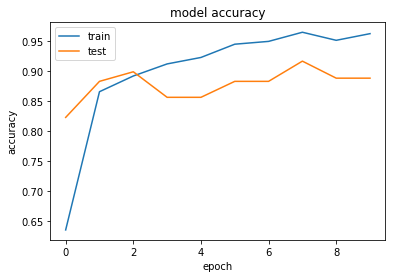

In [0]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

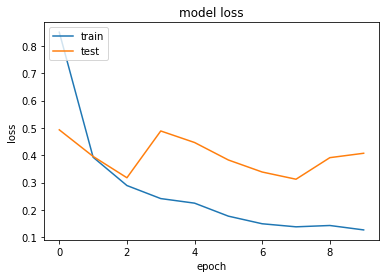

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

###Ideas for further work
1. In the above example we have not optimized the pre-trained weights of the conolutional base. To improve performance you could enable training in all layers (including the convolutoinal base) and re-train the network. This is called *fine-tuning*.
2. Another way to improve model performance is by *data augmentation*. Have a look at the documentation for the [image generator class](https://keras.io/preprocessing/image/) and see what kind of augmentation is possible. Why do you think data augmentation helps improve the performance of your model?
3. Try repeating the above experiments on the MNIST dataset. Take a look here: https://keras.io/examples/mnist_cnn/

##Optional task: Deploying the model
Here is how to deploy the model and integrate with OpenCV.

File path: /content/gdrive/My Drive/data/cat/00000001.jpg


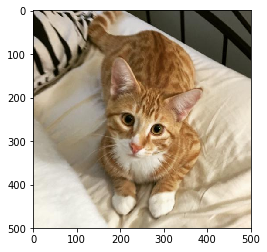

In [0]:
import cv2

# Pick first image of first class
filelist = [x for x in (p/classes[0]).iterdir() if x.is_file()]
img_path = str(filelist[0])
print(f"File path: {img_path}")

# Load and display with OpenCV
img = cv2.imread(img_path)
b,g,r = cv2.split(img)
img = cv2.merge((r,g,b))
plt.imshow(img)

Now, make sure that the image shape and the pixel intensity range is as expected by the network:

In [0]:
img = cv2.resize(img, (120, 120))
img = (img[...,::-1].astype(np.float32))
img /= 127.5
img -= 1.
img = np.expand_dims(img,0)
print(img.shape)

(1, 120, 120, 3)


Run the image through the network:

In [0]:
pred = model.predict(img)[0]
ind = (-pred).argsort()[:3]
latex = [(classes[x],pred[x]) for x in ind]
print(latex)

[('cat', 0.9967332), ('dog', 0.0032662784), ('horse', 5.7683786e-07)]


##Optional task: Exporting to TensorFlow JS and hosting a web service on GitHub
If you want to, you can deploy your model and make a nice web service like this one:
https://klaverhenrik.github.io/transferlearning/

To do that, first export your model to [TensorFlow JS](https://www.tensorflow.org/js) and download all the necessary files as a zip file:

In [0]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

/bin/bash: tensorflowjs_converter: command not found


In [0]:
with open('class_names.txt', 'w') as file_handler:
    for item in classes:
        file_handler.write("{}\n".format(item))

In [0]:
with open('my_classes.js','w') as file_handler:
  file_handler.write("export const IMAGENET_CLASSES = {\n")
  for ix, item in enumerate(classes):
    file_handler.write("  " + str(ix) + ": \'" + item + "\'")
    if ix < len(classes)-1:
      file_handler.write(",")
    file_handler.write("\n")
  file_handler.write("};")

In [0]:
!pip install tensorflowjs 

     |████████████████████████████████| 317kB 7.9MB/s 
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.11.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: six 1.12.0
    Uninstalling six-1.12.0:
      Successfully uninstalled six-1.12.0
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [0]:
model.save('keras.h5')

In [0]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

mkdir: cannot create directory ‘model’: File exists


In [0]:
!cp class_names.txt model/class_names.txt
!cp my_classes.js model/my_classes.js

In [0]:
!zip -r model.zip model 

  adding: model/ (stored 0%)
  adding: model/group1-shard4of5.bin (deflated 8%)
  adding: model/model.json (deflated 95%)
  adding: model/group1-shard5of5.bin (deflated 8%)
  adding: model/group1-shard1of5.bin (deflated 7%)
  adding: model/class_names.txt (stored 0%)
  adding: model/group1-shard3of5.bin (deflated 7%)
  adding: model/group1-shard2of5.bin (deflated 7%)
  adding: model/my_classes.js (deflated 7%)


In [0]:
from google.colab import files
files.download('model.zip')

Now that you have converted you model to TensorFlow JS and downloaded, you can clone [this git repo](https://github.com/klaverhenrik/klaverhenrik.github.io/tree/master/transferlearning) and copy the model files into your own copy of the repo.

The webpage can be hosted on GitHub using [GitHub Pages](https://pages.github.com/).